# Advanced Machine Learning
# Heterogeneous Stacked Ensemble Classifier - The Super Learner
# Aida Sehic

## Import Packages Etc

In [1]:
from IPython.display import display, HTML, Image

import pandas as pd
import numpy as np
from numpy import transpose
from matplotlib import pyplot
import matplotlib.pyplot as plt
import scipy
import sympy 


from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn import model_selection
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn import neural_network
from sklearn import svm 
from sklearn.svm import SVC 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.model_selection._split import check_cv
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import sklearn.preprocessing as skp


%matplotlib inline
#%qtconsole

## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/4e81/f4c95dde9a327026c584b91a3fe691595d1f.pdf) but the stacked ensemble idea has been around for a long time. 

Figure 1 shows a flow diagram of the Super Learner process (this is from (van der Laan et al, 2007). The base classifiers are trained and their outputs are combined along with the training dataset labels into a training set for the stack layer classifier. To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process (described as V-fold in Figure 1). To further add variety to the base estimators a bootstrapping selection (as is used in the bagging ensemble approach).
 
![Super Learner Process Flow](SuperLearnerProcessFlow.png "Logo Title Text 1")
Figure 1: A flow diagram for the Super Learner


### Define the SuperLearnerClassifier Class

In [2]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and 
#ClassifierMixin classes
class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer 
    and a aggregatnio model at the aggregation layer. 
    A k-fold cross validation is used to gnerate training data for the 
    stack layer model.

    Parameters
    ----------
    base_classifiers: A list of base classifiers of different types.
    
    stacked_layer_classifier: The stacked layer classifier that will 
                               be trained on the outputs of the base classifiers
    probability_outputs: bool (default: False)
        If True, indicates that the stacked layer classifier should be trained on 
        probability outputs from the base classifiers. 
        If False (default) than train stacked layer classifier on label outputs 
        from the base classifiers
        
    type_of_model: selection of the stack layer classifier type 
        Stack layer model can be selected from a set of 10 algorithms from scikit-learn
        by setting up the value of a type_of_model parametar to be in a range from 0 to 9
        If type_of_model = i, where i in [0,9], then 
                    stacked_layer_classifier = clsf_type[i]
        Note: clsf_type is the set of following 10 algorithms from scikit-learn:
        clsf_type = [
            DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
            LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
            svm.SVC(kernel='linear', C=100, probability=True),
            KNeighborsClassifier(n_neighbors=6) ,
            RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
            GaussianNB(),
            neural_network.MLPClassifier(hidden_layer_sizes=(400,200,100), alpha = 0.01),
            ensemble.BaggingClassifier(base_estimator = DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6), bootstrap=True, max_samples= 1.0),
            ensemble.AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6), n_estimators=250),
            GradientBoostingClassifier()
        ]
        
    base_clsf_type: selection of base estimators types combination   
        Base estimators types combination can be selected from a specific set of 45 algorithms combinations from scikit-learn
        by setting up the value of a base_clsf_type parametar to be in a range from 0 to 44
        If base_clsf_type = i, where i in [0,44], then 
                    base_classifiers = base_clfs_comb[i]
        Note: base_clfs_comb is defined within the fit part:
        
        
    add_original_input: bool (default: False)
        If True, then training dataset for the stack layer classifier will contain
        outputs/predictions of the base classifiers and the original input
        If False, the stack layer classifier will be trained only on the outputs
        of the base classifiers combined along with dataset labels.
        
    (sklearn.model_selection.check_cv(cv=3, y=None, classifier=False)[source] 
    --> http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.check_cv.html)    
    cv: int, cross-validation generator or an iterable (default: 3)
        Determines the cross-validation splitting strategy. Possible inputs for cv are:
          -> None, to use the default 3-fold cross validation,
          -> integer, to specify the number of folds.
          -> An object to be used as a cross-validation generator.
          -> An iterable yielding train, test splits.
        For integer/None inputs, if classifier is True and 
        y is either binary or multiclass, StratifiedKFold is used. 
        In all other cases, KFold is used.
    stratify: bool (default: True)
        By default is True and it will follow a stratified K-Fold cross validation technique. 
        If the `cv` argument is a specific cross validation technique, this argument is omitted.
    shuffle: bool (default: True)
        If True, whether to shuffle (each stratification of) the data before splitting into batches.
        
    Attributes
    ----------
    


    Notes
    -----
    

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
     
    """
    # Constructor for the classifier object
    def __init__(self, 
                 base_classifiers=[DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
                                   LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
                                   svm.SVC(kernel='linear', C=100, probability=True),
                                   KNeighborsClassifier(n_neighbors=6),
                                   RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
                                   GaussianNB()] , #fixed set of 6 heterogeneous base models
                 stacked_layer_classifier = DecisionTreeClassifier(criterion="entropy", 
                                                                   min_samples_split = 200, 
                                                                   max_depth=6), # stacked layer model is by default decision tree
                 type_of_model=0,
                 base_clsf_type=0,
                 cv=3,
                 stratify=True,
                 shuffle=True,
                 probability_outputs=False,
                 add_original_input=False):
        """Setup a SuperLearner classifier .
        Parameters
        ----------

        Returns
        -------

        """  
        self.base_classifiers = base_classifiers
        self.stacked_layer_classifier = stacked_layer_classifier
        
        self.type_of_model=type_of_model
        self.base_clsf_type=base_clsf_type
        self.cv = cv
        self.stratify = stratify
        self.shuffle = shuffle
        
        self.probability_outputs = probability_outputs
        self.add_original_input = add_original_input
        #self.type_of_model = type_of_model
        

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """     
        
        self.clfs_ = self.base_classifiers
        self.s_clf_ = self.stacked_layer_classifier 
        clsf_type = [
            DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
            LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
            svm.SVC(kernel='linear', C=100, probability=True),
            KNeighborsClassifier(n_neighbors=6) ,
            RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
            GaussianNB(),
            neural_network.MLPClassifier(hidden_layer_sizes=(400,200,100), alpha = 0.01),
            ensemble.BaggingClassifier(base_estimator = DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6), bootstrap=True, max_samples= 1.0),
            ensemble.AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6), n_estimators=250),
            ensemble.GradientBoostingClassifier()
        ]
        
        for i in range(10):    
            if self.type_of_model==i:
                self.s_clf_ = clsf_type[i]
       
            
        #list of some of base classifiers types combinations (45 combination - doesn't include all 15 combinations for 2 types out of 6)    
        base_clfs_comb = [
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6),
             GaussianNB()],
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],  
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],
            
            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6)],

            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],
 
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             GaussianNB()],

            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],  
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             KNeighborsClassifier(n_neighbors=6), 
             GaussianNB()],  
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10), 
             GaussianNB()],  
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6), 
             GaussianNB()],  
 
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],  
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             svm.SVC(kernel='linear', C=100, probability=True),
             GaussianNB(),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],              

            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6), 
             GaussianNB()],  
 
            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],  

            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             GaussianNB(),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],  
        
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],  

            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],  
            
            [svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],  
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True)],
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             KNeighborsClassifier(n_neighbors=6)],
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6)],
            
            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6)],
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             svm.SVC(kernel='linear', C=100, probability=True),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],
            
            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],
                     
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             GaussianNB()],
            
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             svm.SVC(kernel='linear', C=100, probability=True),
             GaussianNB()],
            
            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True),
             GaussianNB()],

            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],
                        
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             KNeighborsClassifier(n_neighbors=6),
             GaussianNB()],
                             
            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],
            
            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],
                        
            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             KNeighborsClassifier(n_neighbors=6),
             GaussianNB()],
                             
            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],

            [svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)],
                        
            [svm.SVC(kernel='linear', C=100, probability=True),
             KNeighborsClassifier(n_neighbors=6),
             GaussianNB()],
                             
            [svm.SVC(kernel='linear', C=100, probability=True),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],
            
            [KNeighborsClassifier(n_neighbors=6),
             RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
             GaussianNB()],
                               
            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             svm.SVC(kernel='linear', C=100, probability=True)],                     
                            
            [LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
             DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6)],                      

            [DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
             svm.SVC(kernel='linear', C=100, probability=True)]                      
        
        ]
        
        for i in range(45):
            if self.base_clsf_type==i:
                self.clfs_ = base_clfs_comb[i]
  
        #To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process
        #check_cv - Input checker utility for building a cross-validator
        #The return value is a cross-validator which generates the train/test splits via the split method.
        cross_validator = check_cv(self.cv, y, classifier=self.stratify)
        if isinstance(self.cv, int):
            # In case of self generated cross-validation strategy override shuffle parameter
            cross_validator.shuffle = self.shuffle
        skf = list(cross_validator.split(X, y))
        
        #Training the base classifiers and generation of the stacked layer training set
        clfs_outputs = np.array([]).reshape(len(y), 0) #base classifiers predictions array
        
        for clf in self.clfs_:
            if not self.probability_outputs:
                clf_outputs = np.array([]).reshape(0, 1) #single base classifier predictions array
            else:
                clf_outputs = np.array([]).reshape(0, len(set(y))) #every classifier will have 10 columns - probability predictions for each class labels
                
            for counter, (training_index, testing_index) in enumerate(skf):
                #To further add variety to the base estimators a bootstrap sampling (bagging) is used each time we train one one of the base estimators
                my_model = ensemble.BaggingClassifier(base_estimator = clf, bootstrap=True, max_samples= 1.0)
                my_model.fit(X[training_index], y[training_index])  # training / fitting
                
                if not self.probability_outputs:                   #testing /predicting
                    predictions = my_model.predict(X[testing_index])
                    predictions = predictions.reshape(predictions.shape[0], 1)
                else:
                    predictions = my_model.predict_proba(X[testing_index])
                clf_outputs = np.vstack([clf_outputs.astype(predictions.dtype),predictions])

            clfs_outputs = np.hstack([clfs_outputs.astype(clf_outputs.dtype),clf_outputs]) #stacked layer training set                
        
    
        #Rearranging the Target/Labels and original input 'X' so they are in line with the way we generated predictions 
        #via stratified k-fold cross-validadion (because of shaffeling)
        rearranged_labels = np.array([]).astype(y.dtype)
        rearranged_X = np.array([]).reshape((0, X.shape[1])).astype(X.dtype)
        for training_index, testing_index in skf:
            rearranged_labels = np.concatenate((rearranged_labels,y[testing_index]))
            rearranged_X = np.concatenate((rearranged_X, X[testing_index]))

        # Training the base models on the entire training set for the 'base_classifiers_predictions' method
        for model in self.clfs_:
            model.fit(X, y)
            

        #Training / fitting the stacked layer classifier
        if self.add_original_input: #Task 8 
            self.s_clf_.fit(np.hstack((rearranged_X, clfs_outputs)),rearranged_labels) # adding the original input 'X' (but with correctly oredered features)  
                                                            #to the input 'clfs_outputs' at the stack layer 
        else: 
            self.s_clf_.fit(clfs_outputs,rearranged_labels) #Training the stacked layer classifier on the base classifiers outputs clfs_outputs
                                            #that are combined along with the training dataset labels 'rearranged_labels'
            
        # Return the classifier
        return self

    def base_classifiers_predictions(self, X):
        #The generation of the stacked layer training set
        #'column_stack' takes a sequence of 1-D arrays - base classifiers 
        #predictions and stack them as columns
        if self.probability_outputs: #Task 3 - training on the probability outputs from the base classifiers
            probability_array = np.asarray([clf.predict_proba(X) for clf in self.clfs_])
            clfs_outputs = np.concatenate(probability_array, axis=1) 
            #without this method I am getting ValueError: X has 3 features per sample; expecting 9
            #that could be solved with 'transform' but this is more elegant
        else: #training on the label outputs from the base classifiers
            clfs_outputs = np.column_stack([clf.predict(X) for clf in self.clfs_])
        return clfs_outputs
    
    # The predict function to make a set of predictions for a 
    #set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        #Stacking base classifiers predictions as the columns for the training set for the stack layer classifier
        clfs_outputs = self.base_classifiers_predictions(X)
        
        #Making a set of predictions for the training data
        if self.add_original_input: 
            return self.s_clf_.predict(np.hstack((X, clfs_outputs))) # adding the original input 'X' to the input 'clfs_outputs'                                                     #at the stack layer 
        else:
            return self.s_clf_.predict(clfs_outputs) #Making a set of predictions on the base classifiers outputs
    
    # The predict function to make a set of predictions for a 
    #set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        clfs_outputs = self.base_classifiers_predictions(X)
        
        if self.add_original_input: 
            return self.s_clf_.predict_proba(np.hstack((X, clfs_outputs))) # adding the original input 'X' to the input 'clfs_outputs' 
                                                            #at the stack layer 
        else:
            return self.s_clf_.predict_proba(clfs_outputs) #Making a set of predictions on the base classifiers outputs 

### Test the SuperLearnerClassifier

Perform a simple test using the SuperLearnClassifier on the Iris dataset

In [14]:
from sklearn.datasets import load_iris
clf = SuperLearnerClassifier(type_of_model=1, base_clsf_type=35)
iris = load_iris()
clf.fit(iris.data, iris.target) #Training data has shape (150, 9) for probability_outputs=True
cross_val_score(clf, iris.data, iris.target, cv=10)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  0.86666667,
        0.93333333,  0.86666667,  1.        ,  1.        ,  1.        ])

In [ ]:
data, target = iris.data, iris.target

np.random.seed(42)

clf0 = DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6)
clf1 = LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear')
clf2 = svm.SVC(kernel='linear', C=100, probability=True)
clf3 = KNeighborsClassifier(n_neighbors=6)
clf4 = RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10)
clf5 = GaussianNB()                             
                              
stacked_clf = SuperLearnerClassifier(type_of_model=1, base_clsf_type=35)


#checking the accurancy of the Super Learner and each base classifier individualy 
for model, name in zip([clf0, clf1, clf2, clf3, clf4, clf5, stacked_clf], 
                      ['Decision Tree', 
                       'Logistic Regression', 
                       'Support Vector Machine',
                       'KNN',
                       'Random Forest',
                       'Naive Bayes', 
                       'SuperLearnerClassifier',]):

    scores = model_selection.cross_val_score(model, data, target, cv=10, scoring='accuracy')
    print(name, '10-fold cross validation scores:\n',scores)
    print("Accuracy (average score):  %0.2f ---> %s" 
          % (scores.mean(), name),'\n')


Decision Tree 10-fold cross validation scores:
 [ 0.33333333  0.33333333  0.33333333  0.33333333  0.33333333  0.33333333
  0.33333333  0.33333333  0.33333333  0.33333333]
Accuracy (average score):  0.33 ---> Decision Tree 

Logistic Regression 10-fold cross validation scores:
 [ 1.          1.          1.          0.93333333  0.93333333  0.93333333
  0.8         1.          1.          1.        ]
Accuracy (average score):  0.96 ---> Logistic Regression 

Support Vector Machine 10-fold cross validation scores:
 [ 1.          1.          1.          1.          0.93333333  1.
  0.86666667  0.93333333  1.          1.        ]
Accuracy (average score):  0.97 ---> Support Vector Machine 

KNN 10-fold cross validation scores:
 [ 1.          0.93333333  1.          1.          0.86666667  0.93333333
  0.93333333  1.          1.          1.        ]
Accuracy (average score):  0.97 ---> KNN 

Random Forest 10-fold cross validation scores:
 [ 1.          0.93333333  1.          0.93333333  0.86

## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [3]:
data_sampling_rate = 0.05 #Setting up a data sampling rate for speeding up testing

Setup the number of folds for all grid searches (should be 5 - 10)

In [4]:
cv_folds = 10

Set up a dictionary to store simple model perofrmance comparions

In [5]:
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

### Load Train Dataset

Load the dataset and explore it. --> Train data

In [7]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset 
                                                    #so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 
           5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head()) #dataset.shape = (3000, 785)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
19987,1,0,0,0,0,0,0,0,0,0,...,119,0,0,0,0,0,0,0,0,0
58105,3,0,0,0,0,0,0,0,0,0,...,189,0,0,3,0,0,0,0,0,0
1732,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,62,58,0,0,0,0
25670,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19234,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examining the distribution of the ten classes

In [8]:
dataset["label"].value_counts()
#dataset['label']=dataset['label'].astype(object)
#dataset.select_dtypes(include=[np.object]).shape[1]

5    326
1    321
9    309
8    303
7    293
3    293
4    292
2    290
0    287
6    286
Name: label, dtype: int64

In [9]:
#Describing columns that are numeric dtypes; it will include: 
#count, mean, std, min, max, and lower, 50, and upper percentiles.
if(dataset.select_dtypes(include=[np.number]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.number]).describe()) 
#Describing columns that are object dtypes; For object dtypes (e.g. timestamps or strings), 
#the index will include the count, unique, most common, and frequency of the most common. 
if(dataset.select_dtypes(include=[np.object]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.object]).describe())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,4.516667,0.000667,0.006333,0.056333,0.137667,0.268000,0.409333,0.848000,1.823000,4.922333,...,35.663000,23.339667,15.564000,16.527000,21.885667,16.943667,8.250667,2.485000,0.907333,0.036667
std,2.876424,0.036515,0.260094,1.960895,3.306714,4.806094,5.610431,8.706942,12.115002,21.077549,...,58.472607,49.033176,40.605511,42.683868,50.887547,44.413196,29.340838,16.688178,9.731237,0.936099
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,2.000000,14.000000,106.000000,150.000000,166.000000,161.000000,188.000000,219.000000,219.000000,...,244.000000,252.000000,243.000000,255.000000,250.000000,244.000000,237.000000,255.000000,255.000000,38.000000


In [10]:
# Check for presence of missing values
print("Missing Values")
#print(dataset.isnull().sum())
print(sum(dataset.isnull().sum())) #no missing values

Missing Values
0


### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

Isolating the descriptive features we are interested in

In [11]:
X = dataset[dataset.columns[1:]] #X.shape=(3000, 784)
Y = np.array(dataset["label"]) #Y.shape=(3000,)

Standardization of Data - transforming data columns to have zero mean and unit variance
Standardized_X = (X – Average) / Std_Deviation

In [12]:
X = (X - X.values.mean()) / X.values.std()
#print(X)

Normalise the data (important for some models)

In [13]:
X = (X - X.values.min())/ (X.values.max() - X.values.min())  #Normalized_X = (X – min)/(max-min)  max= 255, min = 0 --> #X=X/255 
#print(X)

In [14]:
#X=X/255

Extract some higher level features

In [15]:
engineered_features = pd.DataFrame()

# Calcualte percentage of filled pixels and a top and bottom half only version
percent_filled = X.sum(axis = 1)/(28*28)
percent_filled_top = X.iloc[:, 0:392].sum(axis = 1)/(28*14)
percent_filled_bottom = X.iloc[:, 392:784].sum(axis = 1)/(28*14)
engineered_features['percent_filled'] = percent_filled
engineered_features['percent_filled_top'] = percent_filled_top
engineered_features['percent_filled_bottom'] = percent_filled_bottom

#print(engineered_features)
# Calculate the sum of each row
for idx, i in enumerate(range(0, 784, 28)):
    row_sum = X.iloc[:, i:(i + 28)].sum(axis = 1)/28
    engineered_features["row_sum_" + str(idx)] = row_sum

# Calcualte a measure of syymmetry around a horizontal axis
s1 = np.round(np.array(X.iloc[:, 0:392]))
s2 = np.round(np.array(X.iloc[:, 784:391:-1]))
s3 = np.logical_and(s1, s2).astype(int)
symmetry = s3.sum(axis = 1)/(28*28)

engineered_features['symmetry'] = symmetry
display(engineered_features.head(10))

,percent_filled,percent_filled_top,percent_filled_bottom,row_sum_0,row_sum_1,row_sum_2,row_sum_3,row_sum_4,row_sum_5,row_sum_6,...,row_sum_19,row_sum_20,row_sum_21,row_sum_22,row_sum_23,row_sum_24,row_sum_25,row_sum_26,row_sum_27,symmetry
19987,0.235909,0.283303,0.188515,0.089776,0.315546,0.290896,0.301541,0.315406,0.325490,0.337255,...,0.202101,0.203501,0.199720,0.185714,0.180812,0.175070,0.161064,0.161625,0.077731,0.080357
58105,0.318102,0.327661,0.308543,0.000000,0.139076,0.404622,0.431092,0.423810,0.433613,0.430392,...,0.324510,0.323529,0.322969,0.318908,0.315966,0.310924,0.305042,0.327451,0.243557,0.153061
1732,0.225570,0.186014,0.265126,0.037815,0.076751,0.097199,0.134034,0.162605,0.155462,0.170448,...,0.295658,0.299160,0.307843,0.323109,0.332493,0.335714,0.285994,0.119188,0.042297,0.003827
25670,0.140006,0.156753,0.123259,0.131092,0.158683,0.130812,0.142857,0.146218,0.151261,0.159944,...,0.121148,0.116246,0.114286,0.110084,0.109524,0.111204,0.109944,0.113445,0.092997,0.014031
19234,0.506878,0.498850,0.514906,0.000000,0.000000,0.000000,0.000000,0.358543,0.557003,0.676190,...,0.793277,0.780672,0.769328,0.626331,0.199160,0.000000,0.000000,0.000000,0.000000,0.276786
30565,0.168202,0.182143,0.154262,0.164566,0.218207,0.156583,0.168207,0.170028,0.190616,0.187675,...,0.148039,0.148179,0.149580,0.155602,0.156162,0.149440,0.149020,0.152661,0.124090,0.058673
8409,0.359544,0.342787,0.376301,0.133754,0.157843,0.162325,0.278711,0.335154,0.368908,0.384034,...,0.496779,0.492157,0.519608,0.450560,0.186275,0.183473,0.182773,0.182493,0.152801,0.174745
40807,0.169488,0.159754,0.179222,0.041737,0.107283,0.174370,0.205602,0.173109,0.146359,0.161204,...,0.175490,0.176891,0.186975,0.188655,0.189076,0.194398,0.185854,0.209244,0.141036,0.000000
28745,0.193397,0.129652,0.257143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023109,...,0.597759,0.559384,0.193137,0.000560,0.000000,0.000000,0.000000,0.000000,0.000000,0.047194
43967,0.262680,0.259614,0.265746,0.187395,0.289076,0.250140,0.271148,0.268067,0.304902,0.325350,...,0.260644,0.283473,0.282353,0.298319,0.312045,0.314706,0.301401,0.304342,0.190616,0.012755


In [16]:
X = engineered_features
print(X.shape) #With engineered features we reduced dataset from 784 columns to 32

(3000, 32)


Spliting the data into a **training set**, a **vaidation set**, and a **test set**

In [17]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

/Users/aidasehic/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Load Test Dataset

Imprting Fashion MNIST Test Data

In [18]:
test_dataset = pd.read_csv('fashion-mnist_test.csv')
test_dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
test_X = test_dataset[test_dataset.columns[1:]]
test_Y = np.array(test_dataset["label"])
#print(test_X.values.max(),test_X.values.min())

In [20]:
test_X = (test_X - test_X.values.mean()) / test_X.values.std() #Standardization of test_X dataset

In [21]:
test_X = (test_X - test_X.values.min())/ (test_X.values.max() - test_X.values.min())  #Normalized_X = (X – min)/(max-min)

In [22]:
engineered_features_test = pd.DataFrame()

# Calcualte percentage of filled pixels and a top and bottom half only version
percent_filled = test_X.sum(axis = 1)/(28*28)
percent_filled_top = test_X.iloc[:, 0:392].sum(axis = 1)/(28*14)
percent_filled_bottom = test_X.iloc[:, 392:784].sum(axis = 1)/(28*14)
engineered_features_test['percent_filled'] = percent_filled
engineered_features_test['percent_filled_top'] = percent_filled_top
engineered_features_test['percent_filled_bottom'] = percent_filled_bottom

# Calculate the sum of each row
for idx, i in enumerate(range(0, 784, 28)):
    row_sum = test_X.iloc[:, i:(i + 28)].sum(axis = 1)/28
    engineered_features_test["row_sum_" + str(idx)] = row_sum

# Calcualte a measure of syymmetry around a horizontal axis
s1 = np.round(np.array(test_X.iloc[:, 0:392]))
s2 = np.round(np.array(test_X.iloc[:, 784:391:-1]))
s3 = np.logical_and(s1, s2).astype(int)
symmetry = s3.sum(axis = 1)/(28*28)

engineered_features_test['symmetry'] = symmetry

display(engineered_features_test.head(10))

,percent_filled,percent_filled_top,percent_filled_bottom,row_sum_0,row_sum_1,row_sum_2,row_sum_3,row_sum_4,row_sum_5,row_sum_6,...,row_sum_19,row_sum_20,row_sum_21,row_sum_22,row_sum_23,row_sum_24,row_sum_25,row_sum_26,row_sum_27,symmetry
0,0.399620,0.422389,0.376851,0.018347,0.078992,0.185994,0.414286,0.550840,0.540196,0.518347,...,0.388235,0.391737,0.395098,0.395938,0.400560,0.393697,0.370728,0.457843,0.212745,0.161990
1,0.210664,0.236134,0.185194,0.209664,0.250000,0.267647,0.291877,0.267787,0.248880,0.240756,...,0.199160,0.201821,0.199860,0.202941,0.198039,0.191317,0.185294,0.185294,0.155742,0.084184
2,0.168382,0.193377,0.143387,0.051961,0.157563,0.267507,0.189076,0.192577,0.219328,0.205462,...,0.211345,0.240196,0.157423,0.139216,0.113165,0.079272,0.072129,0.028291,0.038375,0.010204
3,0.407893,0.460554,0.355232,0.257143,0.455602,0.452101,0.430532,0.433053,0.462465,0.500560,...,0.374510,0.319888,0.264146,0.236835,0.277311,0.257423,0.475070,0.725350,0.445798,0.103316
4,0.252716,0.325090,0.180342,0.007563,0.281092,0.360924,0.362745,0.369328,0.381933,0.343277,...,0.251261,0.259664,0.216527,0.034594,0.026751,0.017647,0.016387,0.010364,0.010364,0.079082
5,0.270638,0.251210,0.290066,0.047479,0.181513,0.237255,0.223389,0.230952,0.228011,0.247899,...,0.271849,0.238515,0.256162,0.267647,0.272829,0.282353,0.298599,0.286975,0.188375,0.010204
6,0.404432,0.368958,0.439906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.395098,...,0.780532,0.792997,0.885714,0.123950,0.000000,0.000000,0.000000,0.000000,0.000000,0.202806
7,0.290756,0.255282,0.326230,0.045238,0.160784,0.236835,0.185854,0.223389,0.243417,0.255462,...,0.346359,0.344398,0.332773,0.324790,0.347059,0.280532,0.261485,0.311204,0.283193,0.052296
8,0.167462,0.139776,0.195148,0.000000,0.030952,0.163165,0.316947,0.357843,0.205042,0.085294,...,0.124790,0.178571,0.183333,0.178011,0.339916,0.399860,0.423249,0.176331,0.000000,0.033163
9,0.215581,0.257233,0.173930,0.046218,0.245238,0.248319,0.227731,0.203221,0.267227,0.389776,...,0.175350,0.173389,0.176611,0.185014,0.180952,0.190616,0.192297,0.224090,0.107423,0.000000


In [23]:
test_X = engineered_features_test 

## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset (on the training part of the train data)

In [24]:
np.random.seed(42)
clf = SuperLearnerClassifier()
#clf.fit(X_train,y_train)
clf.fit(np.array(X_train),np.array(y_train))

SuperLearnerClassifier(add_original_input=False,
            base_classifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_lea...b_score=False, random_state=None, verbose=0,
            warm_start=False), GaussianNB(priors=None)],
            base_clsf_type=0, cv=3, probability_outputs=False,
            shuffle=True,
            stacked_layer_classifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
            stratify=True, type_of_model=0)

Evaluate the trained classifier

Assess the performance of the Super Learner Classifier on the training set

In [25]:
# Make a set of predictions for the training data
y_pred = clf.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) #normalize=True, 
                                                #sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, 
            rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.828666666667
             precision    recall  f1-score   support

          0       0.79      0.79      0.79       140
          1       0.83      0.92      0.87       156
          2       0.79      0.93      0.85       153
          3       0.99      0.85      0.92       141
          4       0.97      0.95      0.96       141
          5       0.97      0.76      0.85       173
          6       0.61      0.75      0.67       151
          7       0.74      0.97      0.84       153
          8       0.84      0.84      0.84       153
          9       0.99      0.51      0.67       139

avg / total       0.85      0.83      0.83      1500

[[111   5  23   0   0   1   0   0   0   0]
 [  1 143  12   0   0   0   0   0   0   0]
 [  1   5 143   1   0   0   0   0   3   0]
 [ 12   6   2 120   0   0   0   0   1   0]
 [  0   1   0   0 134   0   1   0   5   0]
 [  0   1   0   0   0 132  32   0   7   1]
 [ 15  12   1   0   4   1 113   0   5   0]
 [  0   0   0   0   0   2   0 148  

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,111,5,23,0,0,1,0,0,0,0,140
1,1,143,12,0,0,0,0,0,0,0,156
2,1,5,143,1,0,0,0,0,3,0,153
3,12,6,2,120,0,0,0,0,1,0,141
4,0,1,0,0,134,0,1,0,5,0,141
5,0,1,0,0,0,132,32,0,7,1,173
6,15,12,1,0,4,1,113,0,5,0,151
7,0,0,0,0,0,2,0,148,3,0,153
8,0,0,0,0,0,0,17,8,128,0,153


Assess the performance of the Super Learner Classifier on the validation dataset

In [26]:
# Make a set of predictions for the validation data
y_pred = clf.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) #normalize=True, 
                                                #sample_weight=None

    
model_valid_accuracy_comparisons["Default Super Learner"] = accuracy

print("Accuracy: " + str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_valid, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], 
            colnames=['Predicted'], margins=True)

Accuracy: 0.608333333333
             precision    recall  f1-score   support

          0       0.75      0.62      0.68        64
          1       0.76      0.91      0.83        64
          2       0.34      0.58      0.43        52
          3       0.61      0.46      0.53        71
          4       0.61      0.60      0.60        67
          5       0.78      0.57      0.66        61
          6       0.16      0.20      0.18        45
          7       0.60      0.89      0.72        53
          8       0.86      0.77      0.81        57
          9       0.91      0.44      0.59        66

avg / total       0.66      0.61      0.61       600

[[40  3 13  3  1  0  4  0  0  0]
 [ 0 58  2  3  1  0  0  0  0  0]
 [ 1  3 30  1 10  0  5  0  2  0]
 [ 7  8  9 33  3  0 11  0  0  0]
 [ 0  2 14  6 40  0  4  0  1  0]
 [ 0  0  2  2  0 35 14  6  1  1]
 [ 5  2 14  5  9  0  9  0  0  1]
 [ 0  0  0  0  0  6  0 47  0  0]
 [ 0  0  2  0  1  2  4  3 44  1]
 [ 0  0  2  1  1  2  6 22  3 29]]
Confu

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,40,3,13,3,1,0,4,0,0,0,64
1,0,58,2,3,1,0,0,0,0,0,64
2,1,3,30,1,10,0,5,0,2,0,52
3,7,8,9,33,3,0,11,0,0,0,71
4,0,2,14,6,40,0,4,0,1,0,67
5,0,0,2,2,0,35,14,6,1,1,61
6,5,2,14,5,9,0,9,0,0,1,45
7,0,0,0,0,0,6,0,47,0,0,53
8,0,0,2,0,1,2,4,3,44,1,57


Assess the performance of the Super Learner Classifier on the test dataset

In [27]:
# Make a set of predictions for the test data
y_pred = clf.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) #normalize=True, 
                                            #sample_weight=None

model_test_accuracy_comparisons["Default Super Learner"] = accuracy    
    
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, 
            rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.616666666667
             precision    recall  f1-score   support

          0       0.68      0.60      0.64        83
          1       0.77      0.89      0.83       101
          2       0.49      0.71      0.58        85
          3       0.53      0.47      0.50        81
          4       0.55      0.61      0.58        84
          5       0.71      0.55      0.62        92
          6       0.28      0.32      0.30        90
          7       0.60      0.78      0.68        87
          8       0.86      0.71      0.78        93
          9       0.91      0.50      0.65       104

avg / total       0.65      0.62      0.62       900

[[50 10  8  6  3  0  5  0  1  0]
 [ 1 90  3  7  0  0  0  0  0  0]
 [ 3  2 60  3 11  0  5  0  0  1]
 [ 8  7 17 38  4  0  7  0  0  0]
 [ 0  2 11  5 51  0 12  0  3  0]
 [ 0  0  2  3  0 51 20 14  1  1]
 [11  5 16  6 21  0 29  0  2  0]
 [ 0  0  0  0  0 17  0 68  0  2]
 [ 0  0  2  0  2  0 14  8 66  1]
 [ 0  1  3  4  1  4 11 24  4 52]]
Confu

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,50,10,8,6,3,0,5,0,1,0,83
1,1,90,3,7,0,0,0,0,0,0,101
2,3,2,60,3,11,0,5,0,0,1,85
3,8,7,17,38,4,0,7,0,0,0,81
4,0,2,11,5,51,0,12,0,3,0,84
5,0,0,2,3,0,51,20,14,1,1,92
6,11,5,16,6,21,0,29,0,2,0,90
7,0,0,0,0,0,17,0,68,0,2,87
8,0,0,2,0,2,0,14,8,66,1,93


### ----> Train a Super Learner Classifier using the whole prepared mnist training dataset

In [29]:
'''
np.random.seed(42)
clf = SuperLearnerClassifier()
#clf.fit(X,Y)
clf.fit(np.array(X),np.array(Y))
'''

'\nnp.random.seed(42)\nclf = SuperLearnerClassifier()\n#clf.fit(X,Y)\nclf.fit(np.array(X),np.array(Y))\n'

Evaluate the trained classifier on the mnist test data

In [30]:
'''
# Make a set of predictions for the test data
y_pred = clf.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) #normalize=True,
                                                #sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, 
            rownames=['True'], colnames=['Predicted'], margins=True)
'''

'\n# Make a set of predictions for the test data\ny_pred = clf.predict(test_X)\n\n# Print performance details\naccuracy = metrics.accuracy_score(test_Y, y_pred) #normalize=True,\n                                                #sample_weight=None\nprint("Accuracy: " +  str(accuracy))\nprint(metrics.classification_report(test_Y, y_pred))\n\n# Print confusion matrix\nprint("Confusion Matrix")\npd.crosstab(np.array(test_Y), y_pred, \n            rownames=[\'True\'], colnames=[\'Predicted\'], margins=True)\n'

## Cross Validation Experiment (Task 2)

Classification accuracy is the number of correct predictions made as a ratio of all predictions made.
Most common evaluation metric for classification problems
This metric is suitable for fashion mnist data because:

    --> there is an equal number of observations in each class 
            (6000 for each of the 10 labels - check Examining the distribution of the ten classes:
            dataset["label"].value_counts()) 
    ---> all predictions and prediction errors are equally important (it is equaly important to us to correctly 
        predict Shirts as any other class)

#### Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier - on the train plus validation data from mnist train dataset

In [ ]:
cross_val_score(clf, np.array(X_train_plus_valid), np.array(y_train_plus_valid), cv=10, scoring='accuracy')

### ---> Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier on the entire mnist train data

In [ ]:
#cross_val_score(clf, np.array(X), np.array(Y), cv=10, scoring='accuracy')

## Comparing the Performance of Different Stack Layer Approaches (Task 5)

In [31]:
stack_model_name = [
            'Decision Tree (label outputs)',
            'Decision Tree (probability outputs)',
    
            'Logistic Regression (label outputs)',
            'Logistic Regression (probability outputs)',
    
            'Support Vector Machine (label outputs)',
            'Support Vector Machine (probability outputs)',
    
            'Nearest Neighbour (label outputs)',
            'Nearest Neighbour (probability outputs)',
    
            'Random Forest (label outputs)',
            'Random Forest (probability outputs)',
    
            'Naive Bayes (label outputs)',
            'Naive Bayes (probability outputs)',
    
            'Multy Layer Perception (label outputs)',
            'Multy Layer Perception (probability outputs)',
    
            'Bagging (label outputs)',
            'Bagging (probability outputs)',
    
            'Ada Boost (label outputs)',
            'Ada Boost (probability outputs)',
    
            'Gradient Boosting (label outputs)',
            'Gradient Boosting (probability outputs)'
        ]

In [32]:
#Creating a list of super learners (different models types for stack layer classifier, 
#one trained on label outputs and one on probability outputs)
super_learner_list=[]
for i in range(10):
    super_learner_list.append(SuperLearnerClassifier(type_of_model=i, probability_outputs=False))
    super_learner_list.append(SuperLearnerClassifier(type_of_model=i, probability_outputs=True))
#print(super_learner_list)

In [33]:
#creating empty dictionary that will contain different stacked layer model types for keys (with probability/label outputs info) 
#and mean accuracies of a super learner that uses that stacked layer model type for values
sl_stack_model_accuracy_comparisons = dict() 

In [ ]:
np.random.seed(42)
#checking the accurancy of the Super Learner for different stack layer model types 
for super_learner, stack_name in zip(super_learner_list, stack_model_name):
    scores = cross_val_score(super_learner, np.array(X_train_plus_valid), np.array(y_train_plus_valid), cv=10, scoring='accuracy')
    sl_stack_model_accuracy_comparisons[stack_name]=scores.mean()
    print(stack_name, 'stack model 10-fold cross validation scores:\n', scores)
    print("Accuracy (average score):  %0.2f (+/- %0.2f) ---> %s" 
          % (scores.mean(), scores.std(), stack_name),'\n')    

Decision Tree (label outputs) stack model 10-fold cross validation scores:
 [ 0.61682243  0.6056338   0.62441315  0.63849765  0.60663507  0.59330144
  0.61244019  0.63768116  0.6407767   0.66341463]
Accuracy (average score):  0.62 (+/- 0.02) ---> Decision Tree (label outputs) 



Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

In [34]:
display(sl_stack_model_accuracy_comparisons)

{}

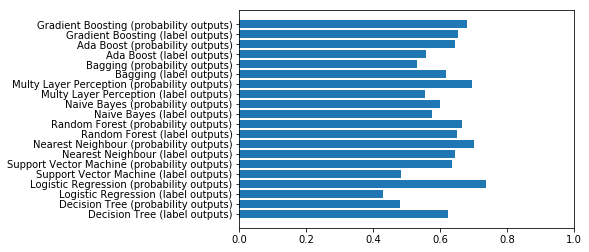

In [37]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(sl_stack_model_accuracy_comparisons)), 
             list(sl_stack_model_accuracy_comparisons.values()), 
             align='center')
_ = plt.yticks(range(len(sl_stack_model_accuracy_comparisons)), 
               list(sl_stack_model_accuracy_comparisons.keys()))

## Grid Search Through SuperLearnerClassifier Architectures & Parameters (Task 7)

Using a grid search through a large set of possible parameters. 
Here we try all 10 different stack layer models, 
45 different base estimators combinations, and
2 different stack layer training data types (with probability outputs and label outputs)
Also, fitting cv = 2 folds for each of 900=10*45*2 candidates, totalling in 1800 fits

Perfrom a grid search experiment to detemrine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

In [ ]:
np.random.seed(42)
# Set up the parameter grid to seaerch
param_grid ={'type_of_model': list(range(0, 10)),\
             'base_clsf_type': list(range(0, 45)),\
             'probability_outputs': ['False', 'True']}

# Perform the search
my_tuned_superlearner = GridSearchCV(SuperLearnerClassifier(), param_grid, cv=2, verbose = 2, return_train_score=True)
my_tuned_superlearner.fit(np.array(X_train_plus_valid), np.array(y_train_plus_valid))

# Print details
print("Best parameters set found on development set:")
display(my_tuned_superlearner.best_params_) #Parameter setting that gave the best results on the hold out data.

model_tuned_params_list["Tuned Super Learner"] = my_tuned_superlearner.best_params_

display(my_tuned_superlearner.best_score_) #Mean cross-validated score of the best_estimator
display(my_tuned_superlearner.cv_results_) #A dict with keys as column headers and values as columns, that can be imported into a pandas DataFrame.

In [39]:
'''
Best parameters set found on development set:
{'base_clsf_type': 27, 'probability_outputs': 'True', 'type_of_model': 1}

0.70428571428571429
'''
print(model_tuned_params_list)

{'Tuned Super Learner': {'base_clsf_type': 27, 'probability_outputs': 'True', 'type_of_model': 1}}


Evaluate the performance of the model selected by the grid search on a hold-out dataset

In [40]:
np.random.seed(42)
# Make a set of predictions for the test data
y_pred = my_tuned_superlearner.predict(X_test) #X_test - hold-out dataset

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) #normalize=True,
                                                #sample_weight=None

model_test_accuracy_comparisons["Tuned Super Learner"] = accuracy

print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, 
            rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.692222222222
             precision    recall  f1-score   support

          0       0.62      0.67      0.64        90
          1       0.86      0.79      0.82        91
          2       0.52      0.56      0.54        84
          3       0.58      0.71      0.64        98
          4       0.60      0.56      0.58       110
          5       0.84      0.84      0.84        82
          6       0.49      0.38      0.43        97
          7       0.87      0.82      0.85       100
          8       0.87      0.90      0.89        73
          9       0.75      0.77      0.76        75

avg / total       0.69      0.69      0.69       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,60,4,3,10,3,1,7,0,2,0,90
1,2,72,1,14,0,0,2,0,0,0,91
2,5,2,47,2,19,0,8,0,1,0,84
3,13,5,2,70,2,1,4,0,1,0,98
4,3,0,21,9,62,0,14,0,0,1,110
5,0,0,0,1,0,69,2,5,1,4,82
6,14,1,10,13,18,0,37,0,3,1,97
7,0,0,0,0,0,6,0,82,1,11,100
8,0,0,3,0,0,1,0,1,66,2,73


In [41]:
print(model_valid_accuracy_comparisons)

{'Default Super Learner': 0.6333333333333333}


In [42]:
print(model_test_accuracy_comparisons)

{'Default Super Learner': 0.60333333333333339, 'Tuned Super Learner': 0.69222222222222218}


In [43]:
print(model_tuned_params_list)

{'Tuned Super Learner': {'base_clsf_type': 27, 'probability_outputs': 'True', 'type_of_model': 1}}


## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer (Task 8)

Evaluate the impact of adding original descriptive features at the stack layer.

In [48]:
np.random.seed(42)
#Using the best setup found in Task 7 and adding original descriptive features at the stack layer.
'''
Best parameters set found on development set:
{'base_clsf_type': 27, 'probability_outputs': 'True', 'type_of_model': 1}

0.70428571428571429
'''
my_best_superlearner = SuperLearnerClassifier(type_of_model=1, base_clsf_type=35, probability_outputs=False, add_original_input=True)
my_best_superlearner.fit(np.array(X_train),np.array(y_train))  #training best setup supe learner

SuperLearnerClassifier(add_original_input=True,
            base_classifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_lea...b_score=False, random_state=None, verbose=0,
            warm_start=False), GaussianNB(priors=None)],
            base_clsf_type=35, cv=3, probability_outputs=False,
            shuffle=True,
            stacked_layer_classifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
            stratify=True, type_of_model=1)

In [49]:
# Make a set of predictions for the training data
y_pred = my_best_superlearner.predict(X_train)

# Print performance details  y_train_plus_valid  
accuracy = metrics.accuracy_score(y_train, y_pred) #normalize=True, 
                                                #sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, 
            rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.698666666667
             precision    recall  f1-score   support

          0       0.70      0.68      0.69       151
          1       0.70      0.90      0.79       146
          2       0.62      0.57      0.59       148
          3       0.61      0.62      0.62       168
          4       0.61      0.56      0.59       140
          5       0.67      0.72      0.69       137
          6       0.56      0.44      0.49       142
          7       0.78      0.83      0.80       158
          8       0.88      0.78      0.83       136
          9       0.81      0.84      0.83       174

avg / total       0.70      0.70      0.69      1500

[[103  22   4  13   3   1   5   0   0   0]
 [  3 132   0   9   1   0   1   0   0   0]
 [  5  11  85  14  21   2  10   0   0   0]
 [ 12  14  11 105   7   7  12   0   0   0]
 [  2   5  31   8  79   2  13   0   0   0]
 [  1   0   2   6   0  98   4  21   0   5]
 [ 19   4   5  15  15  10  62   1   6   5]
 [  0   0   0   0   0  21   0 131  

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,103,22,4,13,3,1,5,0,0,0,151
1,3,132,0,9,1,0,1,0,0,0,146
2,5,11,85,14,21,2,10,0,0,0,148
3,12,14,11,105,7,7,12,0,0,0,168
4,2,5,31,8,79,2,13,0,0,0,140
5,1,0,2,6,0,98,4,21,0,5,137
6,19,4,5,15,15,10,62,1,6,5,142
7,0,0,0,0,0,21,0,131,0,6,158
8,0,0,0,0,4,2,1,4,106,19,136


In [50]:
#Make a set of predictions for the validation data
y_pred = my_best_superlearner.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) #normalize=True, 
                                                #sample_weight=None

    
model_valid_accuracy_comparisons["Best Setup Super Learner"] = accuracy

print("Accuracy: " + str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_valid, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], 
            colnames=['Predicted'], margins=True)

Accuracy: 0.633333333333
             precision    recall  f1-score   support

          0       0.65      0.56      0.60        59
          1       0.67      0.88      0.76        59
          2       0.51      0.52      0.52        69
          3       0.54      0.52      0.53        69
          4       0.45      0.47      0.46        51
          5       0.68      0.59      0.63        51
          6       0.40      0.37      0.38        63
          7       0.83      0.88      0.85        66
          8       0.87      0.69      0.77        58
          9       0.75      0.87      0.81        55

avg / total       0.63      0.63      0.63       600

[[33  9  0  7  2  0  5  0  2  1]
 [ 1 52  3  3  0  0  0  0  0  0]
 [ 3  4 36  4 13  1  8  0  0  0]
 [ 5  5  9 36  4  3  7  0  0  0]
 [ 1  1 11  2 24  0 11  0  0  1]
 [ 0  0  0  6  0 30  0 10  1  4]
 [ 7  6  7  9  8  2 23  0  1  0]
 [ 0  0  0  0  0  6  0 58  0  2]
 [ 1  1  3  0  2  0  2  1 40  8]
 [ 0  0  1  0  0  2  1  1  2 48]]
Confu

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,33,9,0,7,2,0,5,0,2,1,59
1,1,52,3,3,0,0,0,0,0,0,59
2,3,4,36,4,13,1,8,0,0,0,69
3,5,5,9,36,4,3,7,0,0,0,69
4,1,1,11,2,24,0,11,0,0,1,51
5,0,0,0,6,0,30,0,10,1,4,51
6,7,6,7,9,8,2,23,0,1,0,63
7,0,0,0,0,0,6,0,58,0,2,66
8,1,1,3,0,2,0,2,1,40,8,58


In [51]:
# Make a set of predictions for the test data
y_pred = my_best_superlearner.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) #normalize=True, 
                                            #sample_weight=None

model_test_accuracy_comparisons["Best Setup Super Learner"] = accuracy    
    
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, 
            rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.622222222222
             precision    recall  f1-score   support

          0       0.58      0.51      0.54        90
          1       0.67      0.81      0.74        91
          2       0.45      0.45      0.45        84
          3       0.51      0.64      0.57        98
          4       0.57      0.46      0.51       110
          5       0.72      0.77      0.74        82
          6       0.46      0.36      0.40        97
          7       0.83      0.79      0.81       100
          8       0.77      0.75      0.76        73
          9       0.67      0.75      0.71        75

avg / total       0.62      0.62      0.62       900

[[46 16  2 15  2  2  4  0  3  0]
 [ 4 74  3  8  1  0  1  0  0  0]
 [ 2  8 38  7 18  1  8  0  2  0]
 [12  5  8 63  1  1  6  0  2  0]
 [ 2  2 22 10 51  1 19  0  2  1]
 [ 0  0  0  4  0 63  1  7  0  7]
 [12  5  9 14 15  2 35  0  2  3]
 [ 0  0  0  0  0  9  0 79  1 11]
 [ 1  0  2  0  2  4  1  3 55  5]
 [ 0  0  1  2  0  5  1  6  4 56]]
Confu

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,46,16,2,15,2,2,4,0,3,0,90
1,4,74,3,8,1,0,1,0,0,0,91
2,2,8,38,7,18,1,8,0,2,0,84
3,12,5,8,63,1,1,6,0,2,0,98
4,2,2,22,10,51,1,19,0,2,1,110
5,0,0,0,4,0,63,1,7,0,7,82
6,12,5,9,14,15,2,35,0,2,3,97
7,0,0,0,0,0,9,0,79,1,11,100
8,1,0,2,0,2,4,1,3,55,5,73


Training on train plus validation data

In [57]:
np.random.seed(42)
#Using the best setup found in Task 7 and adding original descriptive features at the stack layer.
'''
Best parameters set found on development set:
{'base_clsf_type': 27, 'probability_outputs': 'True', 'type_of_model': 1}

0.70428571428571429
'''
my_best_superlearner = SuperLearnerClassifier(type_of_model=1, base_clsf_type=35, probability_outputs=False, add_original_input=True)
my_best_superlearner.fit(np.array(X_train_plus_valid),np.array(y_train_plus_valid))  #training best setup supe learner

SuperLearnerClassifier(add_original_input=True,
            base_classifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_lea...b_score=False, random_state=None, verbose=0,
            warm_start=False), GaussianNB(priors=None)],
            base_clsf_type=35, cv=3, probability_outputs=False,
            shuffle=True,
            stacked_layer_classifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
            stratify=True, type_of_model=1)

In [58]:
# Make a set of predictions for the training data
y_pred = my_best_superlearner.predict(X_train_plus_valid)

# Print performance details  y_train_plus_valid  
accuracy = metrics.accuracy_score(y_train_plus_valid, y_pred) #normalize=True, 
                                                #sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train_plus_valid, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_train_plus_valid, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train_plus_valid), y_pred, 
            rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.69380952381
             precision    recall  f1-score   support

          0       0.75      0.63      0.69       210
          1       0.69      0.89      0.78       205
          2       0.60      0.59      0.60       217
          3       0.57      0.63      0.60       237
          4       0.60      0.47      0.53       191
          5       0.70      0.73      0.72       188
          6       0.54      0.46      0.49       205
          7       0.81      0.89      0.85       224
          8       0.85      0.75      0.80       194
          9       0.81      0.86      0.84       229

avg / total       0.69      0.69      0.69      2100

[[132  38   6  16   4   6   8   0   0   0]
 [  5 182   2  13   2   1   0   0   0   0]
 [  5  18 129  18  24   6  16   0   1   0]
 [ 15  16  16 150  10  13  17   0   0   0]
 [  1   4  45  15  90   3  28   0   4   1]
 [  0   0   1  10   1 138   4  28   0   6]
 [ 16   5  13  34  15  10  94   1  10   7]
 [  0   0   0   0   0  18   0 199   

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,132,38,6,16,4,6,8,0,0,0,210
1,5,182,2,13,2,1,0,0,0,0,205
2,5,18,129,18,24,6,16,0,1,0,217
3,15,16,16,150,10,13,17,0,0,0,237
4,1,4,45,15,90,3,28,0,4,1,191
5,0,0,1,10,1,138,4,28,0,6,188
6,16,5,13,34,15,10,94,1,10,7,205
7,0,0,0,0,0,18,0,199,0,7,224
8,1,0,3,3,5,2,4,6,145,25,194


In [59]:
# Make a set of predictions for the test data
y_pred = my_best_superlearner.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) #normalize=True, 
                                            #sample_weight=None

model_test_accuracy_comparisons["Best Setup Super Learner"] = accuracy    
    
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, 
            rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.616666666667
             precision    recall  f1-score   support

          0       0.62      0.50      0.55        90
          1       0.65      0.77      0.71        91
          2       0.43      0.49      0.46        84
          3       0.50      0.57      0.53        98
          4       0.56      0.42      0.48       110
          5       0.76      0.79      0.77        82
          6       0.39      0.38      0.39        97
          7       0.84      0.83      0.83       100
          8       0.82      0.77      0.79        73
          9       0.67      0.75      0.71        75

avg / total       0.62      0.62      0.61       900

[[45 15  1 14  4  1  8  0  2  0]
 [ 3 70  3 10  0  0  5  0  0  0]
 [ 1  7 41  7 16  1 10  0  0  1]
 [10  8  8 56  1  3 10  0  2  0]
 [ 1  3 23  9 46  0 22  0  3  3]
 [ 0  0  0  3  0 65  2  8  0  4]
 [13  4 12 13 12  2 37  0  1  3]
 [ 0  0  0  0  0  6  0 83  0 11]
 [ 0  0  3  0  3  3  0  3 56  5]
 [ 0  0  4  1  0  5  0  5  4 56]]
Confu

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,45,15,1,14,4,1,8,0,2,0,90
1,3,70,3,10,0,0,5,0,0,0,91
2,1,7,41,7,16,1,10,0,0,1,84
3,10,8,8,56,1,3,10,0,2,0,98
4,1,3,23,9,46,0,22,0,3,3,110
5,0,0,0,3,0,65,2,8,0,4,82
6,13,4,12,13,12,2,37,0,1,3,97
7,0,0,0,0,0,6,0,83,0,11,100
8,0,0,3,0,3,3,0,3,56,5,73


Training on entire MNIST training data and evaluating on the MNIST test data

In [60]:
np.random.seed(42)
#Using the best setup found in Task 7 and adding original descriptive features at the stack layer.
'''
Best parameters set found on development set:
{'base_clsf_type': 27, 'probability_outputs': 'True', 'type_of_model': 1}

0.70428571428571429
'''
my_best_superlearner = SuperLearnerClassifier(type_of_model=1, base_clsf_type=35, probability_outputs=False, add_original_input=True)
my_best_superlearner.fit(np.array(X),np.array(Y))  #training best setup supe learner

SuperLearnerClassifier(add_original_input=True,
            base_classifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_lea...b_score=False, random_state=None, verbose=0,
            warm_start=False), GaussianNB(priors=None)],
            base_clsf_type=35, cv=3, probability_outputs=False,
            shuffle=True,
            stacked_layer_classifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
            stratify=True, type_of_model=1)

In [61]:
# Make a set of predictions for the test data
y_pred = my_best_superlearner.predict(X)

# Print performance details
accuracy = metrics.accuracy_score(Y, y_pred) #normalize=True, 
                                            #sample_weight=None

model_test_accuracy_comparisons["Best Setup Super Learner"] = accuracy    
    
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(Y, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(Y, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(Y), y_pred, 
            rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.694
             precision    recall  f1-score   support

          0       0.70      0.62      0.65       300
          1       0.70      0.90      0.79       296
          2       0.64      0.60      0.62       301
          3       0.59      0.60      0.59       335
          4       0.57      0.54      0.56       301
          5       0.71      0.76      0.73       270
          6       0.55      0.48      0.52       302
          7       0.81      0.86      0.84       324
          8       0.90      0.76      0.82       267
          9       0.79      0.83      0.81       304

avg / total       0.69      0.69      0.69      3000

[[185  49  10  32   6   5  13   0   0   0]
 [  9 266   3  14   2   0   2   0   0   0]
 [  6  22 182  22  43   6  17   0   1   2]
 [ 31  29  13 201  18  17  26   0   0   0]
 [  3   6  55  23 164   5  40   0   5   0]
 [  0   0   2  14   1 205   5  34   0   9]
 [ 31   7  16  31  43  12 146   1   8   7]
 [  0   0   0   0   0  25   0 280   0  19]
 

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,185,49,10,32,6,5,13,0,0,0,300
1,9,266,3,14,2,0,2,0,0,0,296
2,6,22,182,22,43,6,17,0,1,2,301
3,31,29,13,201,18,17,26,0,0,0,335
4,3,6,55,23,164,5,40,0,5,0,301
5,0,0,2,14,1,205,5,34,0,9,270
6,31,7,16,31,43,12,146,1,8,7,302
7,0,0,0,0,0,25,0,280,0,19,324
8,0,0,2,3,11,8,5,8,202,28,267


In [62]:
# Make a set of predictions for the test data
y_pred = my_best_superlearner.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) #normalize=True, 
                                            #sample_weight=None

model_test_accuracy_comparisons["Best Setup Super Learner"] = accuracy    
    
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print(metrics.confusion_matrix(test_Y, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, 
            rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6433
             precision    recall  f1-score   support

          0       0.69      0.60      0.64      1000
          1       0.69      0.90      0.78      1000
          2       0.52      0.55      0.53      1000
          3       0.55      0.62      0.58      1000
          4       0.53      0.48      0.50      1000
          5       0.65      0.69      0.67      1000
          6       0.45      0.34      0.39      1000
          7       0.75      0.83      0.79      1000
          8       0.88      0.68      0.76      1000
          9       0.73      0.75      0.74      1000

avg / total       0.64      0.64      0.64     10000

[[599 123  31 109  28  20  66   1  20   3]
 [ 25 900  18  44   6   4   3   0   0   0]
 [ 28  83 547  51 168  15  90   0   9   9]
 [ 64 109  43 624  27  48  80   0   3   2]
 [  9  26 235  80 480  12 133   0  18   7]
 [  8   4   1  49   3 688  16 156   3  72]
 [126  63 121 142 145  46 340   0  12   5]
 [  0   0   0   0   0 104   0 828   5  63]


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,599,123,31,109,28,20,66,1,20,3,1000
1,25,900,18,44,6,4,3,0,0,0,1000
2,28,83,547,51,168,15,90,0,9,9,1000
3,64,109,43,624,27,48,80,0,3,2,1000
4,9,26,235,80,480,12,133,0,18,7,1000
5,8,4,1,49,3,688,16,156,3,72,1000
6,126,63,121,142,145,46,340,0,12,5,1000
7,0,0,0,0,0,104,0,828,5,63,1000
8,6,1,24,24,47,54,17,39,675,113,1000


#### Perfroming a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier 
#### with the best setup from the task 7 and added original input to the input at the stack layer

In [63]:
scores = cross_val_score(my_best_superlearner, np.array(X_train_plus_valid), np.array(y_train_plus_valid), cv=10, scoring='accuracy')

In [64]:
print(scores)
print(scores.mean())

[ 0.61214953  0.62441315  0.61502347  0.657277    0.62085308  0.62679426
  0.66985646  0.68115942  0.67961165  0.61463415]
0.640177216312


## Explore the Ensemble Model (Task 9)

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.

#### Strenghts of correlations between base estimators

Using Pearson correlation to measure diversity/correlation. We want base estimators to be weakly correlated/diverse, hence we want pearson correlation to be close to 0

Note: Pearson correlation coefficient is a measure of the linear correlation between two variables X and Y.

The Pearson correlation coefficient, r, can take a range of values from +1 to -1. A value of 0 indicates that there is no association between the two variables. A value greater than 0 indicates a positive association; that is, as the value of one variable increases, so does the value of the other variable.

The stronger the association of the two variables, the closer the Pearson correlation coefficient, r, will be to either +1 or -1 depending on whether the relationship is positive or negative, respectively. 

Achieving a value of +1 or -1 means that all your data points are included on the line of best fit – there are no data points that show any variation away from this line. Values for r between +1 and -1 (for example, r = 0.8 or -0.4) indicate that there is variation around the line of best fit. The closer the value of r to 0 the greater the variation around the line of best fit. 

In [29]:
base_classifiers=[DecisionTreeClassifier(criterion="entropy", min_samples_split = 200, max_depth=6),
            LogisticRegression(C=1.8, max_iter=1000, multi_class='ovr', solver= 'liblinear'),
            svm.SVC(kernel='linear', C=100, probability=True),
            KNeighborsClassifier(n_neighbors=6) ,
            RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=10),
            GaussianNB()]  

#Training the base classifiers
for clf in base_classifiers:
    clf.fit(X,Y)
        
#The generation of the stacked layer training set
clfs_outputs = np.column_stack([clf.predict(X) for clf in base_classifiers])

#print(np.transpose(clfs_outputs))               

In [30]:
print('Calculating a Pearson correlation coefficient and the p-value to test non-correlation:\n')
#The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
for i in range(5):
    for j in range(i+1,6):
        print('Base model',i+1,'and base model', j+1,':',scipy.stats.pearsonr(np.transpose(clfs_outputs)[i], np.transpose(clfs_outputs)[j]))

Calculating a Pearson correlation coefficient and the p-value to test non-correlation:

Base model 1 and base model 2 : (0.81940498253004379, 0.0)
Base model 1 and base model 3 : (0.81130830527324016, 0.0)
Base model 1 and base model 4 : (0.79868155928073614, 0.0)
Base model 1 and base model 5 : (0.76708317158918926, 0.0)
Base model 1 and base model 6 : (0.84207836067546082, 0.0)
Base model 2 and base model 3 : (0.88728677868888728, 0.0)
Base model 2 and base model 4 : (0.83600372586948324, 0.0)
Base model 2 and base model 5 : (0.7888351857611553, 0.0)
Base model 2 and base model 6 : (0.84047731106177737, 0.0)
Base model 3 and base model 4 : (0.85438383309037236, 0.0)
Base model 3 and base model 5 : (0.82058598724362786, 0.0)
Base model 3 and base model 6 : (0.82049675343658912, 0.0)
Base model 4 and base model 5 : (0.84121308847880816, 0.0)
Base model 4 and base model 6 : (0.82895585641053005, 0.0)
Base model 5 and base model 6 : (0.77181380976840241, 0.0)


In [31]:
#another way
df=pd.DataFrame(data=clfs_outputs)
df.corr(method='pearson', min_periods=1)

,0,1,2,3,4,5
0,1.000000,0.819405,0.811308,0.798682,0.767083,0.842078
1,0.819405,1.000000,0.887287,0.836004,0.788835,0.840477
2,0.811308,0.887287,1.000000,0.854384,0.820586,0.820497
3,0.798682,0.836004,0.854384,1.000000,0.841213,0.828956
4,0.767083,0.788835,0.820586,0.841213,1.000000,0.771814
5,0.842078,0.840477,0.820497,0.828956,0.771814,1.000000


In [32]:
clfs_outputs_tr=np.transpose(clfs_outputs)
print(clfs_outputs_tr)

mat = np.array(clfs_outputs_tr)  
_, inds = sympy.Matrix(mat).T.rref()   #linear independant rows by using: sympy.Matrix.rref:
inds

[[1 3 3 ..., 5 4 4]
 [1 0 6 ..., 5 2 4]
 [1 0 6 ..., 5 2 4]
 [1 3 2 ..., 5 4 4]
 [1 3 2 ..., 5 2 4]
 [1 0 3 ..., 7 4 4]]


(0, 1, 2, 3, 4, 5)

For classification (such is our case: 10 labels for predictors), classification accuracy is appropriate measure

Some of the appropriate measures for classification are: accuracy, geometric mean, precision, recall, ROC 

In [39]:
#Y - true labels
#clfs_outputs_tr[i] - predicted labels by model i
#print(len(clfs_outputs_tr[0]), len(Y))


for i in range(6):
    print('\n Performance of your model',i,':')
    print('Accuracy score:', metrics.accuracy_score(Y, clfs_outputs_tr[i]))
    print("Accuracy: " + str(accuracy))
    print('Classification Report:', metrics.classification_report(Y, clfs_outputs_tr[i]))
    #print('Confusion Matrix:', metrics.confusion_matrix(Y, clfs_outputs_tr[i]))
    # Print nicer confusion matrix
    print("Confusion Matrix")
    print(pd.crosstab(np.array(Y),clfs_outputs_tr[i], rownames=['True'], 
                        colnames=['Predicted'], margins=True))


 Performance of your model 0 :
Accuracy score: 0.621333333333
Accuracy: 0.616666666667
Classification Report:              precision    recall  f1-score   support

          0       0.46      0.57      0.51       287
          1       0.92      0.69      0.79       321
          2       0.43      0.66      0.52       290
          3       0.44      0.66      0.53       293
          4       0.60      0.60      0.60       292
          5       0.82      0.69      0.75       326
          6       0.00      0.00      0.00       286
          7       0.67      0.82      0.74       293
          8       0.73      0.79      0.76       303
          9       0.77      0.68      0.72       309

avg / total       0.59      0.62      0.60      3000

Confusion Matrix
Predicted    0    1    2    3    4    5    7    8    9   All
True                                                        
0          164    6   26   70    4    2    1   14    0   287
1           24  222   15   58    2    0    0    0 

/Users/aidasehic/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
